In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For machine learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import calibration_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [126]:
df = pd.read_csv('Marketing_Leads_India.csv')
df.head()


,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,...,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,...,No,NaN,NaN,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,...,No,NaN,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,...,No,NaN,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Creating Model Encoders


In [205]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

df_copy = df.copy()

# Normalize problematic values
df_copy.replace(['', 'Select', 'Not Provided'], np.nan, inplace=True)

# Handle categorical/object columns
categorical_cols = df_copy.select_dtypes(include='object').columns

label_encoders = {}

for col in categorical_cols:
    df_copy[col] = df_copy[col].fillna('unknown')  # Fill missing with placeholder
    le = LabelEncoder()
    df_copy[col] = le.fit_transform(df_copy[col])
    # Save encoder using column name as-is
    label_encoders[col] = le

# Load encoders
with open("label_encoders.pkl", "wb") as f:
    pickle.dump(label_encoders, f)




### Trainig the Model

In [206]:
X = df_copy.drop('Converted', axis=1)  # Features
y = df_copy['Converted']               # Target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [208]:
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)



### Predicting and presenting top 5 leads


In [215]:

# Get predicted probabilities for each class (column 0 = class 0, column 1 = class 1)
probabilities = model.predict_proba(X_test)

# Extract probabilities for class 1 ("Converted")
y_prob = probabilities[:, 1]

# Create a copy of X_test and add the predicted conversion probability
top_leads = X_test.copy()
top_leads["Conversion Probability"] = (y_prob * 100).round(2)

# Sort leads by predicted conversion probability (highest first)
top_leads = top_leads.sort_values(by="Conversion Probability", ascending=False)

# Show the top 5 leads with the highest predicted probability of conversion
top_leads.head(5)


,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity,Conversion Probability
4772,614103,2,10,0,0,0.0,0,0.0,12,12,...,3,6,3,3,NaN,NaN,0,0,12,95.85
2680,633926,2,10,0,0,0.0,0,0.0,12,12,...,3,6,3,3,NaN,NaN,0,0,12,95.82
4791,614036,2,10,0,0,0.0,0,0.0,12,12,...,3,6,3,3,NaN,NaN,0,0,12,95.66
2684,633914,2,10,0,0,0.0,0,0.0,12,12,...,3,6,3,3,NaN,NaN,0,0,12,95.62
5785,605332,2,10,0,0,0.0,0,0.0,12,12,...,3,6,3,3,NaN,NaN,0,0,12,95.57


### Present accuracy compare to a random prediction


In [132]:
random_preds = np.random.choice([0, 1], size=len(y_test))

model_preds = model.predict(X_test)

print("Random guess accuracy:", accuracy_score(y_test, random_preds))
print("Traind model accuracy:", accuracy_score(y_test, model_preds))

Random guess accuracy: 0.5205627705627706
Traind model accuracy: 0.887987012987013


### Cross Validation Accuracy - between 10 diffrenet folds


In [133]:
from sklearn.model_selection import cross_val_score

# Perform 10-fold cross-validation
rf_scores = cross_val_score(model, X, y, cv=10, scoring='accuracy')
mean_score = np.mean(rf_scores)
std_score = np.std(rf_scores)

# Print scores
print("Accuracy scores for each fold:")
print(np.round(rf_scores, 4))
print(f"\nAverage accuracy: {round(mean_score * 100, 2)}%")
print(f"Standard deviation: {round(std_score * 100, 2)}%")

# Interpretation
if std_score < 0.03:
    print("\nConclusion: The model is stable – its performance is consistent across different folds.")
elif std_score < 0.05:
    print("\nConclusion: The model is generally stable, with slight variation between folds.")
else:
    print("\nConclusion: The model is not stable – performance varies significantly depending on the data split.")


Accuracy scores for each fold:
[0.8766 0.8939 0.8972 0.8972 0.8517 0.8755 0.8994 0.9026 0.868  0.8236]

Average accuracy: 87.86%
Standard deviation: 2.41%

Conclusion: The model is stable – its performance is consistent across different folds.


## Features Correlation Matrix - Checks if there are 2 or more highly correalted features

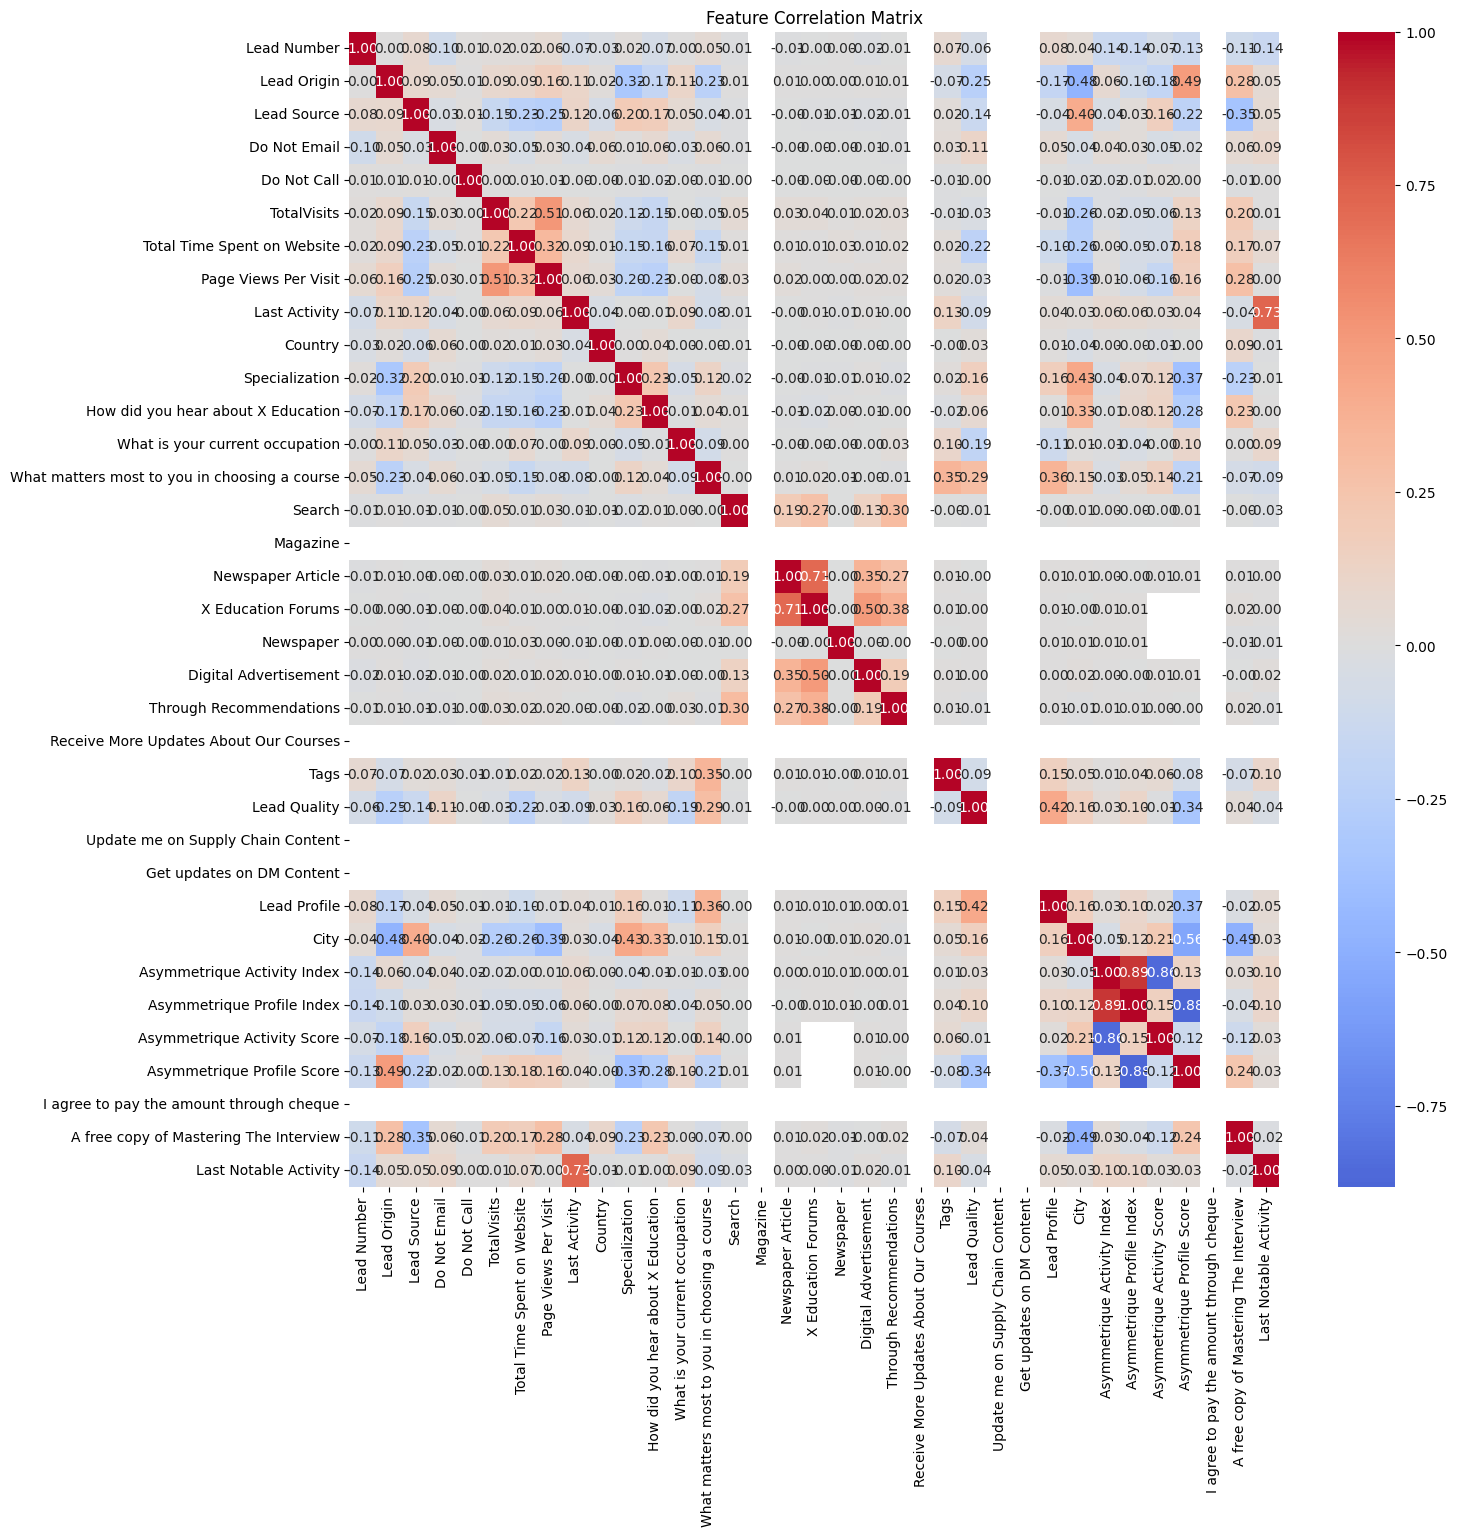

In [134]:

plt.figure(figsize=(15, 15))  # Grpah Size
sns.heatmap(X.corr(), cmap='coolwarm', annot=True, fmt=".2f", center=0)
plt.title("Feature Correlation Matrix")
plt.show()


In [135]:

def find_high_correlation_pairs(df, threshold=0.9):
    """
    Finds and returns pairs of features in the dataframe with correlation above the given threshold.
    Only checks the upper triangle of the correlation matrix to avoid duplicates.
    """
    corr_matrix = df.corr().abs()
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    high_corr_pairs = []

    for col in upper_triangle.columns:
        for row in upper_triangle.index:
            corr_value = upper_triangle.loc[row, col]
            if pd.notnull(corr_value) and corr_value > threshold:
                high_corr_pairs.append((row, col, round(corr_value, 3)))

    return high_corr_pairs

# Run the function on your feature dataframe X
high_corr_features = find_high_correlation_pairs(X, threshold=0.9)

# Print results
if high_corr_features:
    print("Highly correlated feature pairs (correlation > 0.9):\n")
    for f1, f2, corr in high_corr_features:
        print(f"{f1} ↔ {f2} | Correlation = {corr}")
else:
    print("No feature pairs found with correlation above 0.9.")


No feature pairs found with correlation above 0.9.


In [136]:
import pickle
with open("model.pkl", "wb") as f:
    pickle.dump(model, f)


## Pipline Test Improvement (ignore this)

In [197]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import pickle


df_clean = df.copy()
df_clean.replace(['', 'Select', 'Not Provided'], np.nan, inplace=True)

X = df_clean.drop("Converted", axis=1)
y = df_clean["Converted"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

categorical_cols = X.select_dtypes(include='object').columns.tolist()
numeric_cols = X.select_dtypes(include='number').columns.tolist()

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessor = ColumnTransformer(transformers=[
    ('cat', categorical_transformer, categorical_cols),
    ('num', numeric_transformer, numeric_cols)
])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

pipeline.fit(X, y)


with open("model_pipeline.pkl", "wb") as f:
    pickle.dump(pipeline, f)

In [199]:
with open("model_pipeline.pkl", "rb") as f:
    model = pickle.load(f)







np.float64(0.06)